# Data Visualisation Project - Data Exploration

## Initialisation

In [5]:
%pylab inline
import pandas as pd

from data_vis.models import get_session, Program, Major, Faculty

session = get_session()

programs = session.query(Program).all()
faculties = session.query(Faculty).all()

Populating the interactive namespace from numpy and matplotlib


In [68]:
def img_saver(filename):
    savefig('../io/imgs/{}.png'.format(filename), dpi=300)
    savefig('../io/imgs/{}_trans.png'.format(filename), dpi=300, transparent=True)
    savefig('../io/imgs/{}.svg'.format(filename))

## Univariate Data

Simple one dimensional data sets.


In [2]:
print('Number of Faculties:', session.query(Faculty).count())
print('Number of Programs:', session.query(Program).count())
print('Number of Majors:', session.query(Major).count())

Number of Faculties: 6
Number of Programs: 127
Number of Majors: 2001


## Bivariate Data

Visualisations of 2 dimesional data sets.

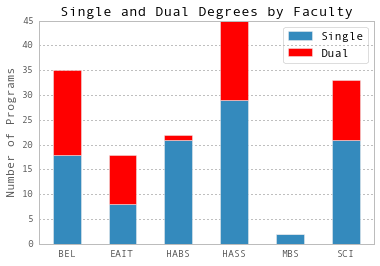

In [70]:
def plot_num_programs():
    # Get, count, and sort program offers.
    singles = pd.Series([fac.id for prog in programs for fac in prog.faculties if len(prog.faculties) == 1]).value_counts()
    doubles = pd.Series([fac.id for prog in programs for fac in prog.faculties if len(prog.faculties) == 2]).value_counts()
    singles = singles.sort_index()
    doubles = doubles.sort_index()
    
    single_counts, double_counts = [], []
    
    for fac in singles.keys():
        single_counts.append(singles.get(fac, 0))
        double_counts.append(doubles.get(fac, 0))
    
    n = 6  # Number of faculties (bars).
    ind = np.arange(n) + 0.25  # X locations of bars.
    width = 0.5  # Bar width.
    
    p1 = plt.bar(ind, single_counts, width, color='#348ABD')
    p2 = plt.bar(ind, double_counts, width, color='r', bottom=single_counts)
    
    plt.ylabel('Number of Programs')
    plt.title('Single and Dual Degrees by Faculty')
    plt.xticks(ind + width / 2, singles.keys())
    plt.legend((p1[0], p2[0]), ('Single', 'Dual'))
    plt.grid(axis='x')
#     img_saver('faculty_degrees')
    plt.show()

plot_num_programs()

### Median OP:

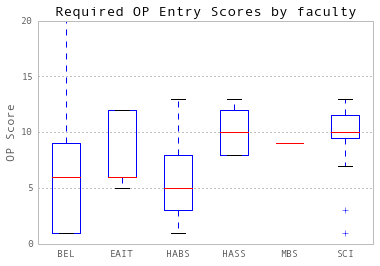

In [71]:
def plot_op_data():
    faculty_ops = {}
    for single in (prog for prog in programs if len(prog.faculties) == 1):
        fac_id = single.faculties[0].id
        if single.op:
            faculty_ops[fac_id] = faculty_ops.get(fac_id, list()) + [single.op]
        
    sorted_ops = [v for k,v in sorted(faculty_ops.items())]
    boxplot(sorted_ops)
    plt.xticks([1, 2, 3, 4, 5, 6], sorted(faculty_ops.keys()))
    plt.ylabel('OP Score')
    plt.title('Required OP Entry Scores by faculty')
    plt.grid(axis='x')
    img_saver('faculty_entry_ops')

plot_op_data()

### Dual Degree Heatmap

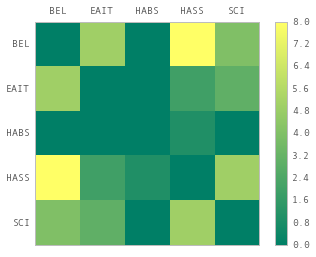

In [72]:
def plot_duals_heatmap():
    fac_pairs = [{prog.faculties[0].id, prog.faculties[1].id} for prog in programs if len(prog.faculties) == 2]
    fac_ids = [faculty.id for faculty in faculties if faculty.id != 'MBS']
    
    # Initialise empty matrix.
    data = np.zeros((len(fac_ids), len(fac_ids)))
    
    pair_coords = [tuple(map(fac_ids.index, coords)) for coords in fac_pairs]
    
    for x, y in pair_coords:
        data[x, y] += 1
        data[y, x] += 1
                
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', cmap='summer')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + fac_ids)
    ax.set_yticklabels([''] + fac_ids)
    ax.grid(False)
#     plt.title('Heatmap of Faculty Associations by Dual Degrees')
#     savefig('../io/faculty_heatmap.svg', dpi=300)
    img_saver('faculty_dual_degrees')

plot_duals_heatmap()

## Financial Analysis

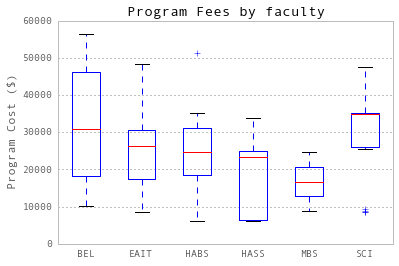

In [80]:
def plot_cost_data():
    fac_costs = {}
    
    for single in (prog for prog in programs if len(prog.faculties) == 1 and prog.cost < 8e4):
        fac_id = single.faculties[0].id
        if single.cost:
            fac_costs[fac_id] = fac_costs.get(fac_id, list()) + [single.cost]
        
    sorted_costs = [v for k,v in sorted(fac_costs.items())]
    boxplot(sorted_costs)
    plt.xticks([1, 2, 3, 4, 5, 6], sorted(fac_costs.keys()))
    plt.ylabel('Program Cost ($)')
    plt.title('Program Fees by faculty')
    plt.grid(axis='x')
    img_saver('faculty_fees_no_outliers')

plot_cost_data()

###  All in this together

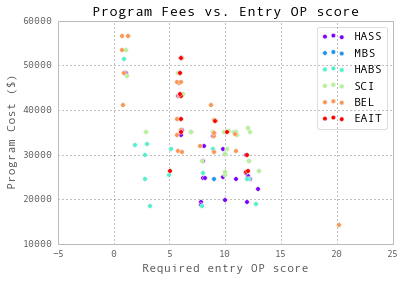

In [96]:
def super_scatter():
    def rand_jitter(arr):
        stdev = .01*(max(arr)-min(arr))
        return arr + np.random.randn(len(arr)) * stdev
    
    fac_data = {}
    
    for program in programs:
        for faculty in faculties:
            if faculty in program.faculties and program.op and program.cost:
                fac_data[faculty.id] = fac_data.get(faculty.id, list()) + [(program.op, program.cost)]

    colors = iter(cm.rainbow(np.linspace(0, 1, len(fac_data))))
    
    for fac, fac_points in fac_data.items():
        xl, yl = array(fac_points).T
        scatter(rand_jitter(xl), yl, label=fac, c=next(colors))

    plt.title('Program Fees vs. Entry OP score')
    plt.xlabel('Required entry OP score')
    plt.ylabel('Program Cost ($)')
    plt.legend()
    img_saver('all_scatter')
    show()
    
super_scatter()